In [1]:
import os
import yaml
from torch.utils.data import DataLoader
import argparse

from GeospatialFM.data import get_datasets
from GeospatialFM.models import *
# from utils import load_config
from torchgeo.samplers import RandomGeoSampler
from matplotlib import pyplot as plt

from transformers import TrainingArguments, Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from GeospatialFM.utils import setup, get_eval_fn, get_data, init_distributed_device
from GeospatialFM.data import *
from GeospatialFM.models import *
from GeospatialFM.loss import *

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np
from torch.utils.data import ConcatDataset
import segmentation_models_pytorch as smp
from collections import OrderedDict

from sklearn.decomposition import PCA
from tqdm import tqdm, trange

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exp_name = "mae_base_dist"
device = "cpu"
args = {'exp_name': exp_name,
        'config_file': 'GeospatialFM/configs/cvit_mae.yaml',
        'opts': None, 
        'save_config': False}
args = argparse.Namespace(**args)
args.debug = True
args.finetune = False
device = init_distributed_device(args)
cfg, _ = setup(args)
args

Namespace(exp_name='mae_base_dist', config_file='GeospatialFM/configs/cvit_mae.yaml', opts=None, save_config=False, debug=True, finetune=False, distributed=False, world_size=1, rank=0, local_rank=0, device='cuda:0')

In [3]:
data = get_data(cfg)
train_dl = data['train'].dataloader
test_dl = data['test'].dataloader

In [4]:
train_imgs = next(train_dl.__iter__())['image']
test_imgs = next(test_dl.__iter__())['image']

In [5]:
L_train = train_imgs.permute(1, 0, 2, 3).flatten(1).transpose(0, 1)
shuffle_idx = np.random.permutation(L_train.shape[0])
L_train = L_train[shuffle_idx[:5000]]

L_test = test_imgs.permute(1, 0, 2, 3).flatten(1).transpose(0, 1)
# shuffle_idx = np.random.permutation(L_test.shape[0])
# L_test = L_test[shuffle_idx[:5000]]

$$L = M \times \alpha$$

$L \in \mathbb{R}^C$: per-channel feature of a pixel

$M \in \mathbb{R}^{C\times p}$: basis of the pixel features

$\alpha \in \mathbb{R}^p$: the ratio of each basis to form $L$

$C$: number of channels

$p$: number of basis, or number of objects

### Intuition
Assum each pixel ($C$-dim vector) in the image is linearly composed by the spectral features($p$). 

In [6]:
pca = PCA(n_components=10)
pca.fit(L_train)

PCA(n_components=10)

In [7]:
M = pca.components_
M.shape

mmt = torch.from_numpy(M.T @ M)
mmt.shape

torch.Size([13, 13])

In [8]:
L_train.shape, L_test.shape

(torch.Size([5000, 13]), torch.Size([16056320, 13]))

In [9]:
# convert L_test to float32
L_test = L_test.float().to('cuda')
mmt = mmt.float().to('cuda')
torch.abs(torch.mm(L_test, mmt) - L_test).mean()

tensor(0.0075, device='cuda:0')

In [10]:
shuffle_channel = np.random.permutation(13)
inp_channels = shuffle_channel[:6]
mask_channels = shuffle_channel[6:]
mask_channels = np.array([0, 1, 2, 3, 6, 7, 8])
inp_channels = np.array([4, 5, 8, 9, 10, 11])

In [11]:
M_m = M[:, inp_channels]
L_test_m = L_test[:, inp_channels]

In [12]:
M_m.shape, L_test_m.shape

((10, 6), torch.Size([16056320, 6]))

In [13]:
recon_all_mat = torch.from_numpy(M_m.T @ M).float().to('cuda')
recon_mat = torch.from_numpy(M_m.T @ M_m).float().to('cuda')
recon_mat.shape, recon_all_mat.shape

(torch.Size([6, 6]), torch.Size([6, 13]))

In [14]:
M_t = M[:, mask_channels]
L_test_t = L_test[:, mask_channels]
M_t.shape, L_test_t.shape

((10, 7), torch.Size([16056320, 7]))

In [15]:
torch.abs(torch.mm(L_test_m, recon_mat) - L_test_m).mean()

tensor(0.1770, device='cuda:0')

In [16]:
test_img = test_imgs[100]
test_img.shape

torch.Size([13, 224, 224])

In [17]:
L = test_img.flatten(1).transpose(0, 1).float().to('cuda')[:, inp_channels]
L.shape

torch.Size([50176, 6])

In [18]:
recon_all = torch.mm(L, recon_all_mat).transpose(0, 1).reshape(13, 224, 224)
recon_all.shape

torch.Size([13, 224, 224])

In [19]:
test_imgs.shape

torch.Size([320, 13, 224, 224])

In [20]:
vis_id = 0
vis_t = test_img.cpu().numpy()
vis_r = recon_all.cpu().numpy()

In [21]:
vis_t.shape

(13, 224, 224)

Text(0.5, 0.98, 'PCA_results')

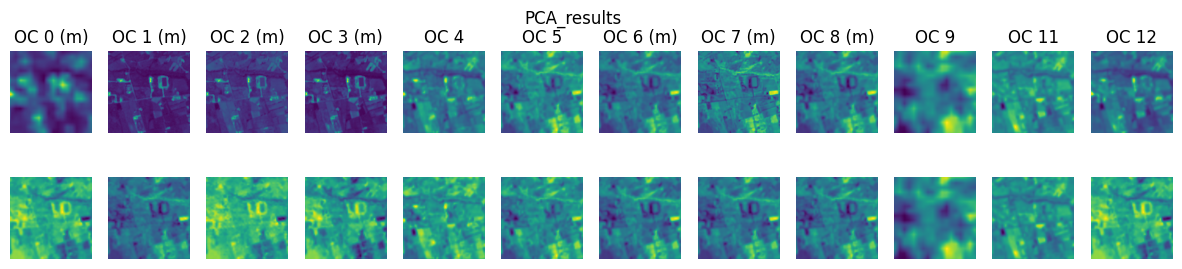

In [85]:
fig, ax = plt.subplots(2, 12, figsize=(15, 3))
for j in range(12):
    if j >= 10:
        vis = j + 1
    else:
        vis = j
    ax[0, j].imshow(vis_t[vis])    
    if j in mask_channels:
        ax[0, j].set_title(f'OC {vis} (m)')
    else:
        ax[0, j].set_title(f'OC {vis}')
    ax[0, j].axis('off')
for j in range(12):
    if j >= 10:
        vis = j + 1
    else:
        vis = j
    ax[1, j].imshow(vis_r[vis])
    # ax[1, j].set_title(f'Channel {j}')
    ax[1, j].axis('off')
fig.suptitle("PCA_results")